In [172]:
#%pip install numba

#%!pip install quantecon

In [173]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import ARDL



In [174]:
import pandas as pd

# Load the data
file_path = 'CPI UK.csv'
df = pd.read_csv(file_path, index_col=0, header=None)

# Map month abbreviations to numbers
month_map = {
    'JAN': '01', 'FEB': '02', 'MAR': '03', 'APR': '04',
    'MAY': '05', 'JUN': '06', 'JUL': '07', 'AUG': '08',
    'SEP': '09', 'OCT': '10', 'NOV': '11', 'DEC': '12'
}

# Convert index to 'yyyymm' format as strings
def to_yyyymm(idx):
    try:
        year, month = idx.split()
        return f"{year}{month_map[month.upper()]}"
    except Exception:
        return idx  # Leave as is if not in expected format

df.index = df.index.map(to_yyyymm)

# Reset index to access it as a column
df.reset_index(inplace=True)
df.columns = ['date', 'Index Price']

# Drop first row if it's not a date
df = df[1:]

df['Index Price'] = df['Index Price'].rolling(window=3).mean()

# Filter only rows where last 2 digits of 'date' are in ['03', '06', '09', '12']
df_sliced = df[df['date'].str[-2:].isin(['03', '06', '09', '12'])].copy()

# Show result
print(df_sliced)


       date  Index Price
3    198803    48.566667
6    198806    49.500000
9    198809    49.900000
12   198812    50.466667
15   198903    51.000000
..      ...          ...
432  202312   131.966667
435  202403   132.266667
438  202406   133.833333
441  202409   134.100000
444  202412   135.233333

[148 rows x 2 columns]


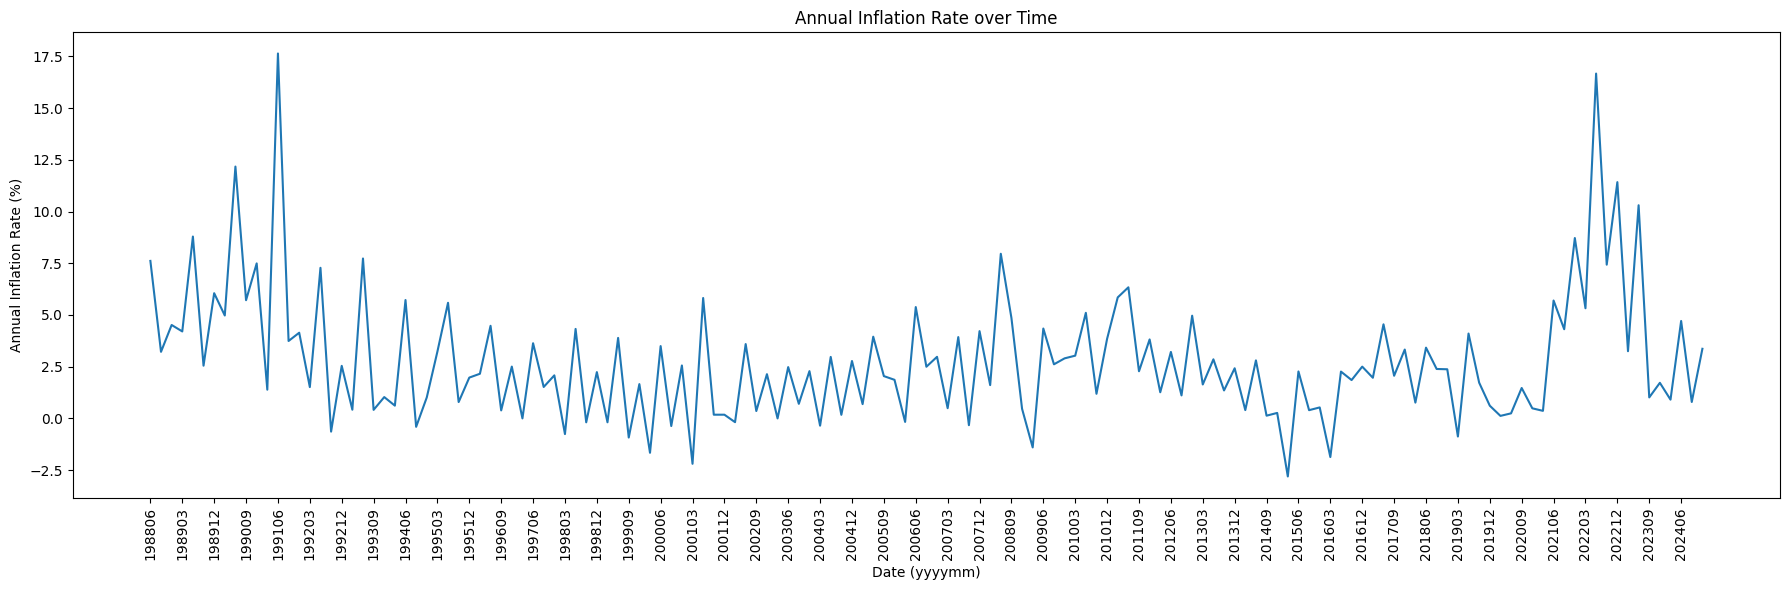

In [175]:
# Calculate one-quarter (annualized) inflation rate
df_sliced['Annual Inflation Rate'] = 400 * np.log(df_sliced['Index Price'] / df_sliced['Index Price'].shift(1))

# Drop the rows with NaN values due to the shift operation
df_inflation = df_sliced.dropna(subset=['Annual Inflation Rate'])

# Display the resulting DataFrame
df_inflation

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))
plt.plot(df_inflation['date'], df_inflation['Annual Inflation Rate'])

# Set labels
plt.xlabel('Date (yyyymm)')
plt.ylabel('Annual Inflation Rate (%)')
plt.title('Annual Inflation Rate over Time')

# Display x-axis labels every 3rd point
plt.xticks(df_inflation['date'][::3], rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()


In [176]:
df_inflation


,date,Index Price,Annual Inflation Rate
6,198806,49.500000,7.614098
9,198809,49.900000,3.219333
12,198812,50.466667,4.516820
15,198903,51.000000,4.205032
18,198906,52.133333,8.791563
...,...,...,...
432,202312,131.966667,1.721304
435,202403,132.266667,0.908289
438,202406,133.833333,4.710063
441,202409,134.100000,0.796218


# **Stationary Test with ADF for annual CPI inflation Rate, from the result we get stationary with 9% confidence level (p-value 0.0178)**



In [177]:


from statsmodels.tsa.stattools import adfuller

# Extract the Annual Inflation Rate series
inflation_rate_series = df_inflation['Annual Inflation Rate']

# Perform the ADF test
adf_result = adfuller(inflation_rate_series)

# Display the results
adf_output = pd.Series(adf_result[0:4], index=['Test Statistic', 'p-value', '# of Lags Used', 'Number of Observations Used'])
for key, value in adf_result[4].items():
    adf_output[f'Critical Value ({key})'] = value

print("Augmented Dickey-Fuller Test Results:")
print(adf_output)



Augmented Dickey-Fuller Test Results:
Test Statistic                  -2.790274
p-value                          0.059676
# of Lags Used                  14.000000
Number of Observations Used    132.000000
Critical Value (1%)             -3.480888
Critical Value (5%)             -2.883697
Critical Value (10%)            -2.578586
dtype: float64


# ** In paper terminology there is average inflation, but we do not need to use average, furthermore because the data is stationary already, we do not need to take differencing anymore**




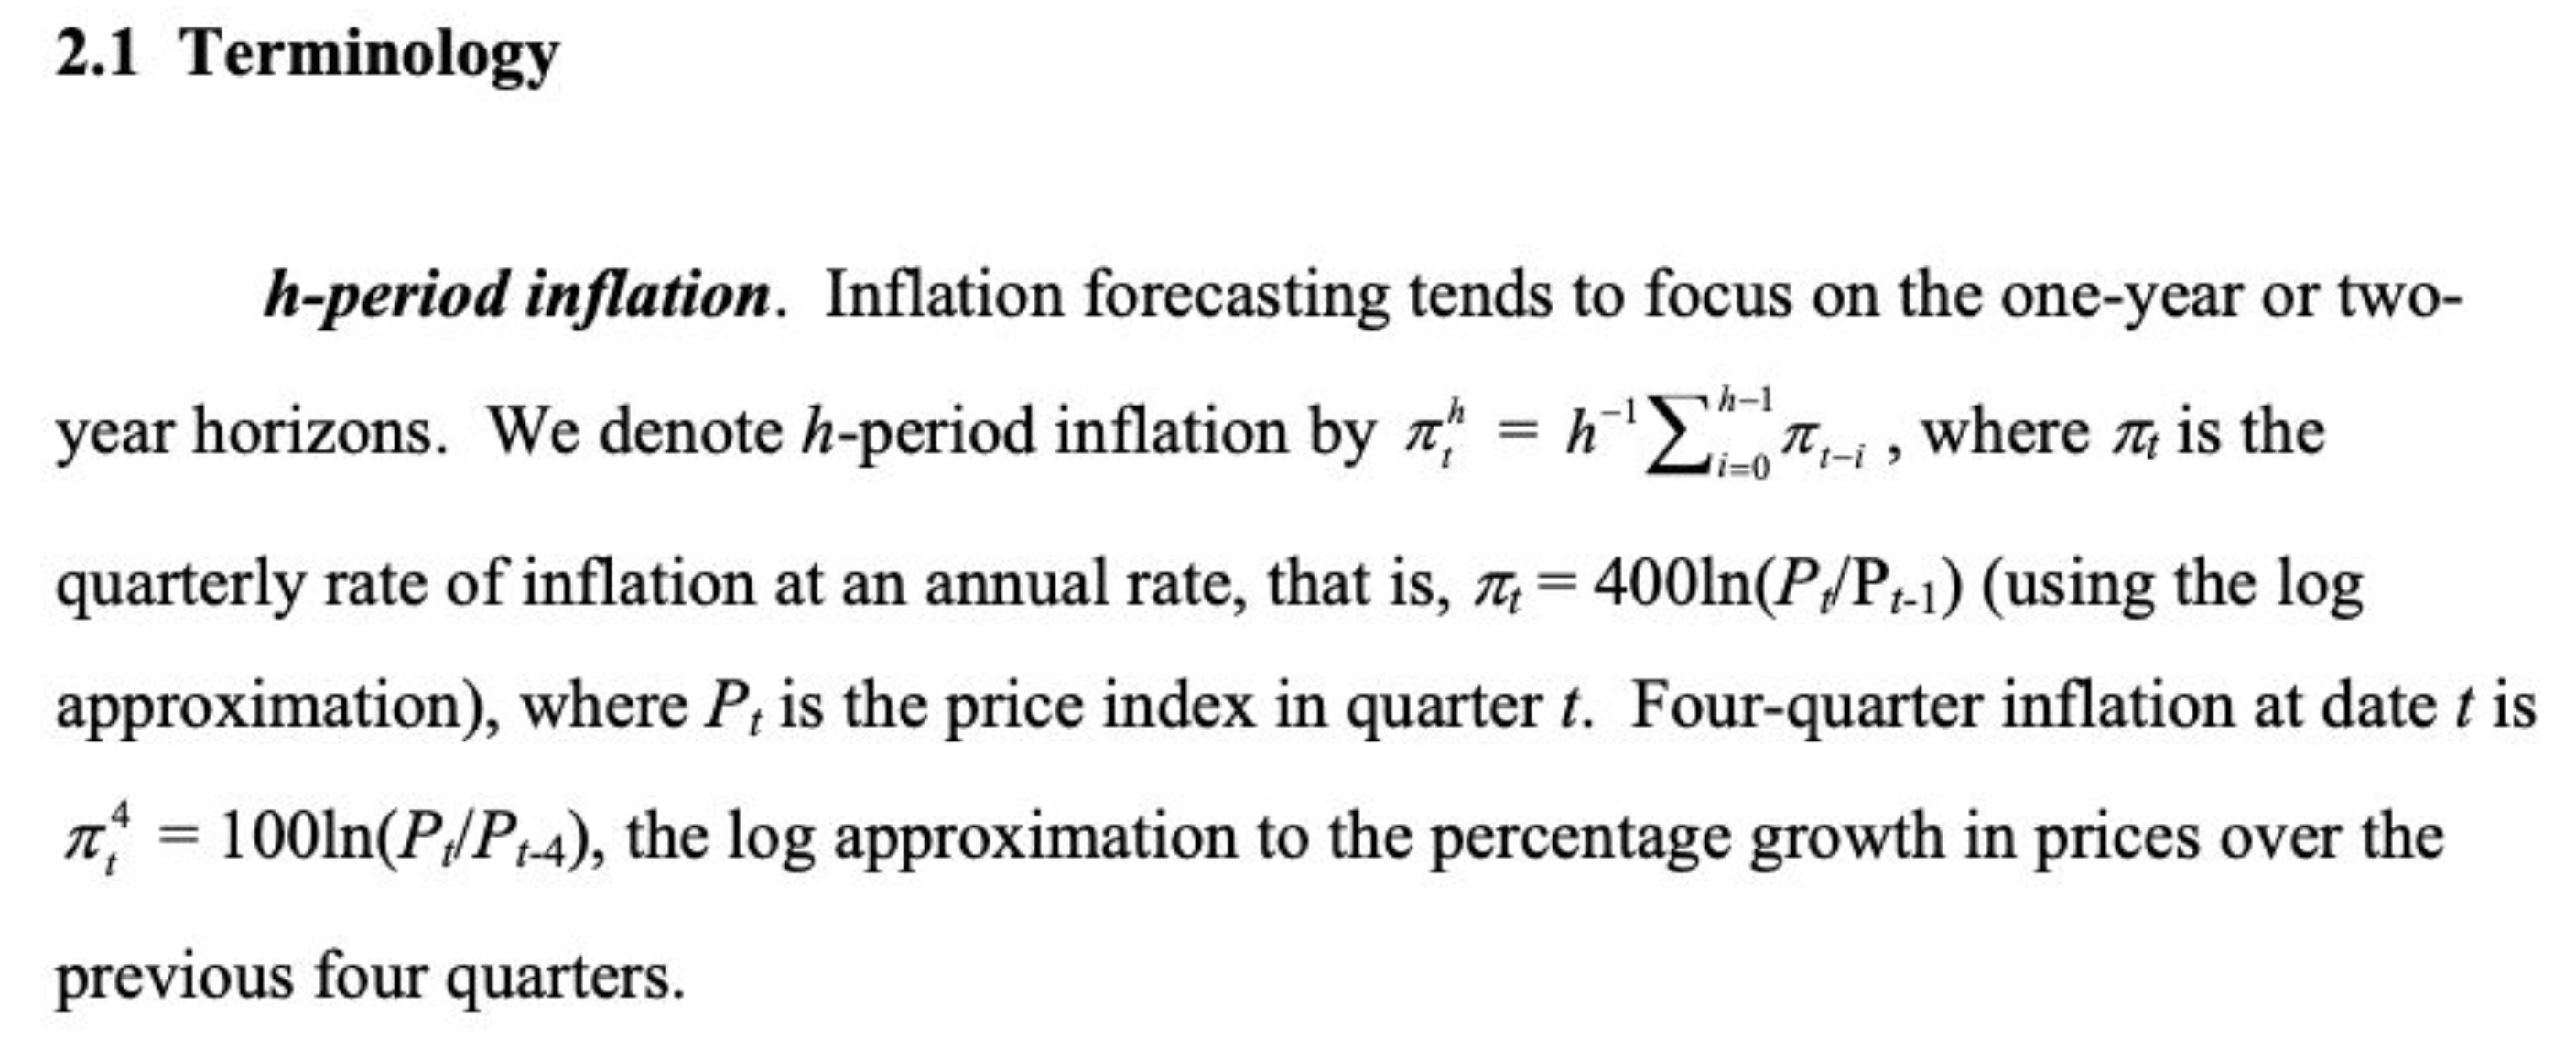

Do we have to take average of infation rate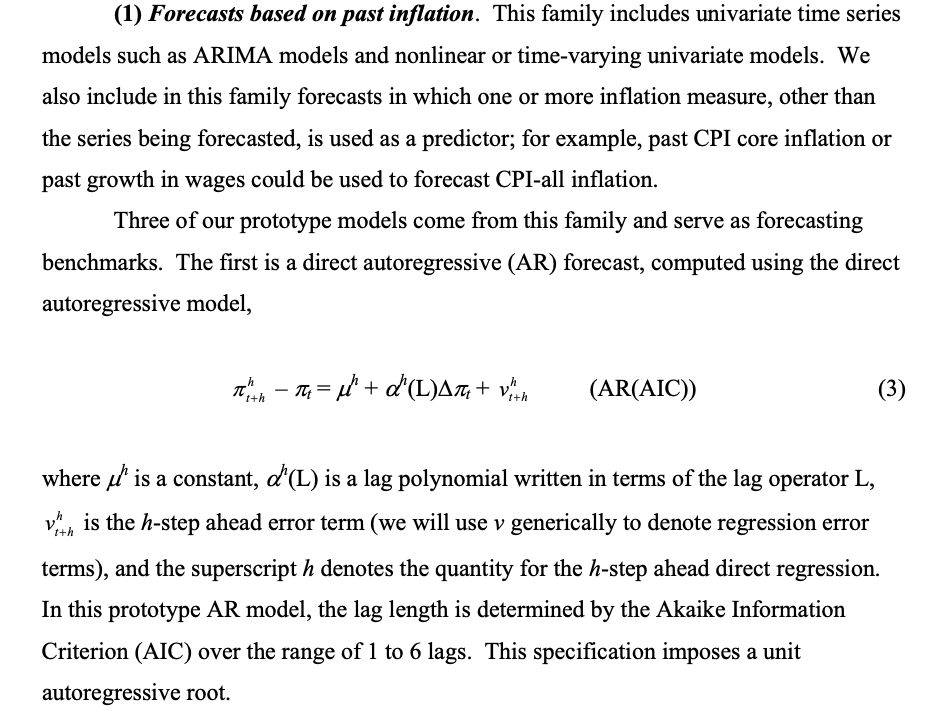

what if the data is stationary already?

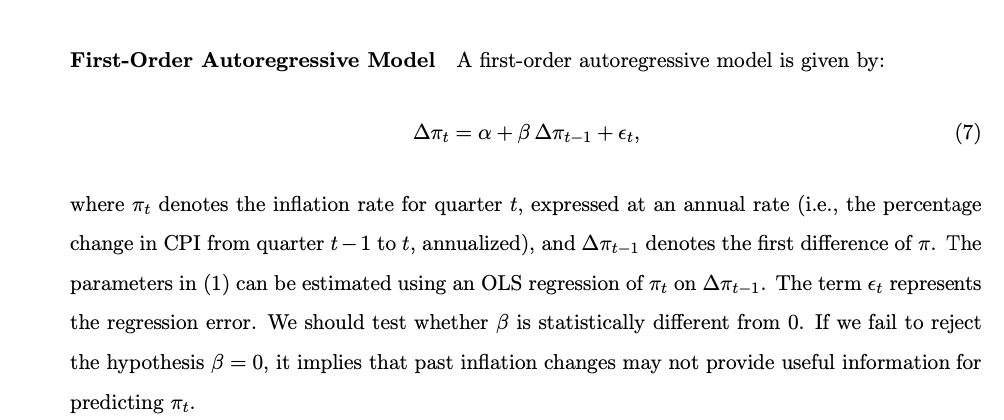

# **We can see the data is correlated between its lag with ACF plot and Cutoff determination with PACF to determine the best AR lag, which in here is at lag 6**


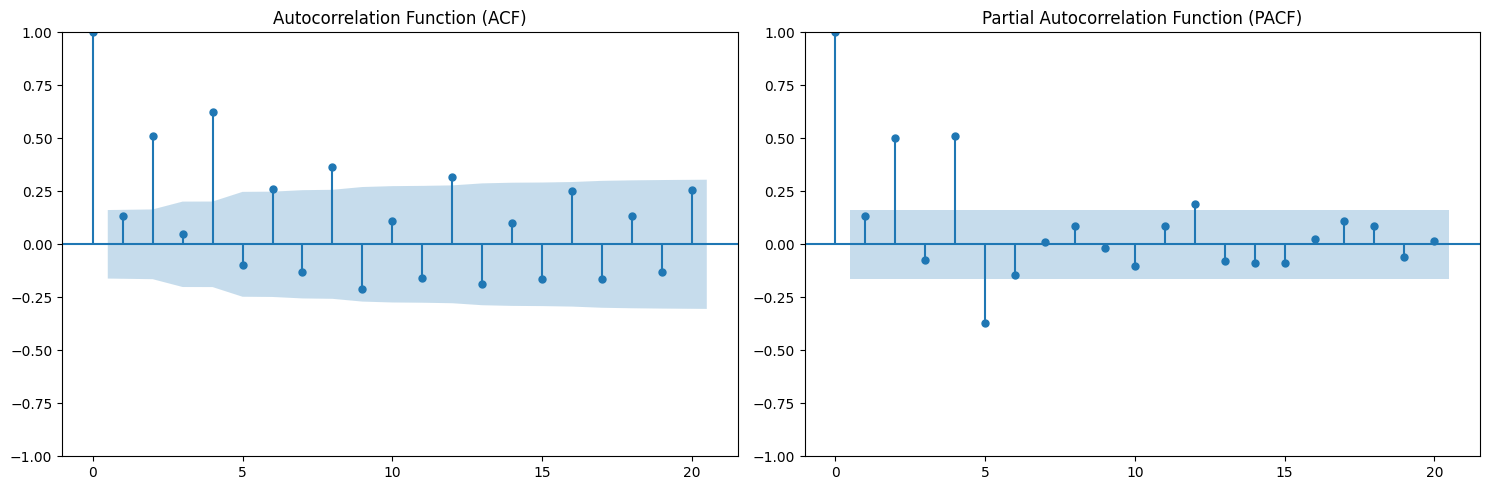

In [178]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotting the ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# ACF Plot
plot_acf(inflation_rate_series, lags=20, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF Plot
plot_pacf(inflation_rate_series, lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()



# **ORiginal AR analysis,along with residual ACF Plot & LB test to check the residual is iid and homoscedasticity for AR(1) and AR(6), we get heterocedasticity for AR(1) because there is correlation between residual in ACF plot and lb test p value is really low,

#However with AR(6) we get good result with p value above 95 % confidence level and ACF plot residual is below the threshold at 95% confidence level, therefore we chose AR(6) as the best model **

#AR(1) coefficient p value is also insignificant but some AR(6) p-value is significant at 95% confidence level)

---

**bold text**

In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf

def calculate_AR_model(df_inflation, lags):

    # Extract the 'Annual Inflation Rate' column
    inflation_rates = df_inflation['Annual Inflation Rate']

    # Fit the AR model
    model = AutoReg(inflation_rates, lags=lags)
    model_fit = model.fit()

    # Print the model summary
    print(model_fit.summary())

    # Get the AR coefficients (excluding the intercept term)
    ar_coef = model_fit.params[1:]

    # Print AR coefficients
    print("\nAR Coefficients:")
    print(ar_coef)

    # Get the residuals
    residuals = model_fit.resid

    # Plot the ACF of residuals
    plt.figure(figsize=(12, 6))
    plot_acf(residuals, lags=12, alpha=0.05)
    plt.title("Autocorrelation Function (ACF) of Residuals")
    plt.show()

    # Perform the Ljung-Box test on residuals
    lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
    print("Ljung-Box Test Results for Residuals:")
    print(lb_test)

    # Return results
    return model_fit, ar_coef, lb_test, residuals


                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                        AutoReg(1)   Log Likelihood                -371.030
Method:                  Conditional MLE   S.D. of innovations              3.072
Date:                   Tue, 15 Apr 2025   AIC                            748.060
Time:                           14:27:05   BIC                            757.010
Sample:                                1   HQIC                           751.696
                                     147                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.3787      0.340      6.988      0.000       1.712       3.046
Annual Inflation Rate.L1     0.1347      0.081      1.656      0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<Figure size 1200x600 with 0 Axes>

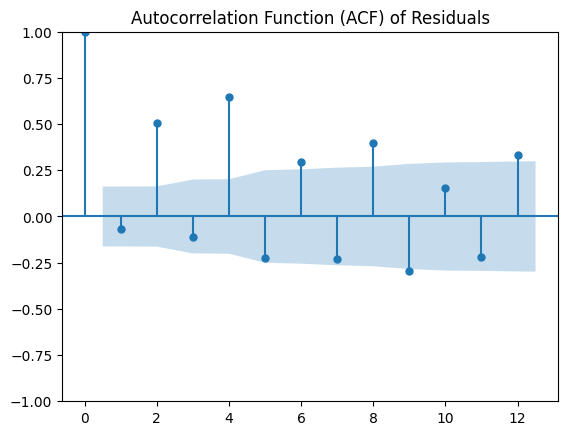

Ljung-Box Test Results for Residuals:
       lb_stat     lb_pvalue
10  175.986201  1.594520e-32


In [180]:
model_fit, ar_coef, lb_test, residuals = calculate_AR_model(df_inflation, lags=1)


                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                        AutoReg(6)   Log Likelihood                -303.349
Method:                  Conditional MLE   S.D. of innovations              2.080
Date:                   Tue, 15 Apr 2025   AIC                            622.698
Time:                           14:27:05   BIC                            646.288
Sample:                                6   HQIC                           632.284
                                     147                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.9553      0.303      3.149      0.002       0.361       1.550
Annual Inflation Rate.L1     0.2947      0.083      3.533      0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


<Figure size 1200x600 with 0 Axes>

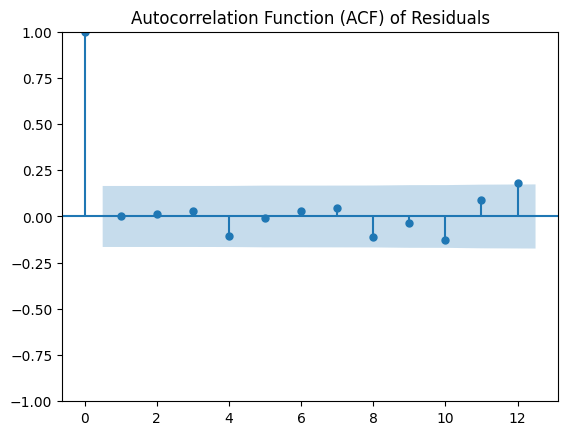

Ljung-Box Test Results for Residuals:
    lb_stat  lb_pvalue
10  6.73724   0.749996


In [181]:
model_fit, ar_coef, lb_test, residuals = calculate_AR_model(df_inflation, lags=6)

#Linear State Space Model of AR(6)

In [182]:
#!pip install quantecon  #toinstall remove#

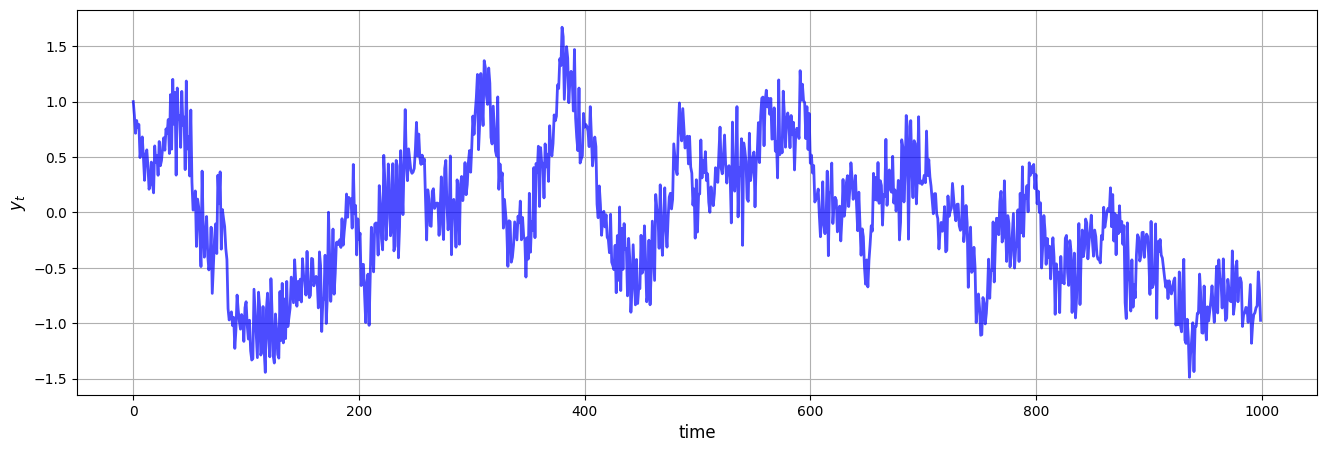

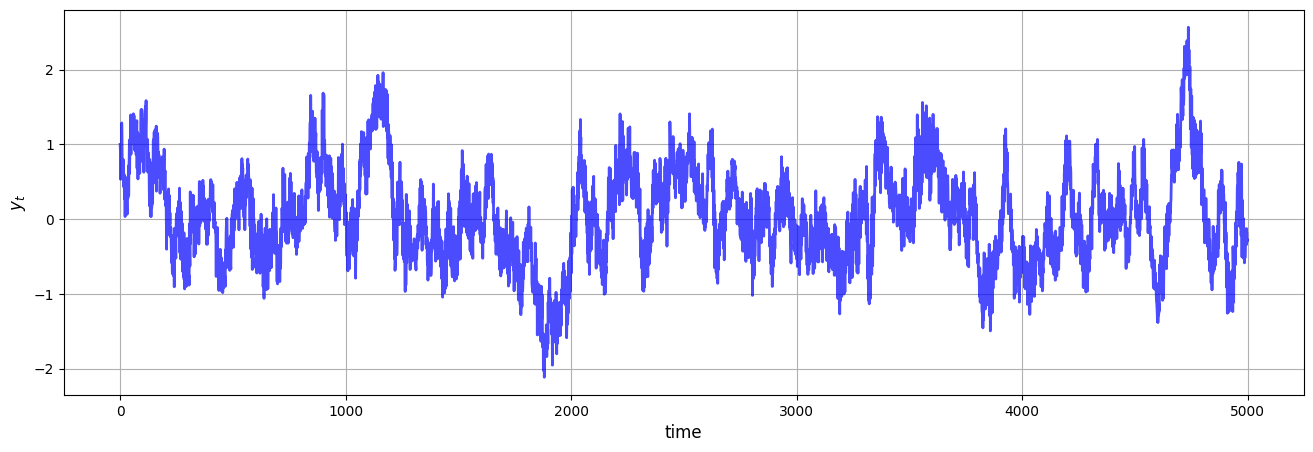

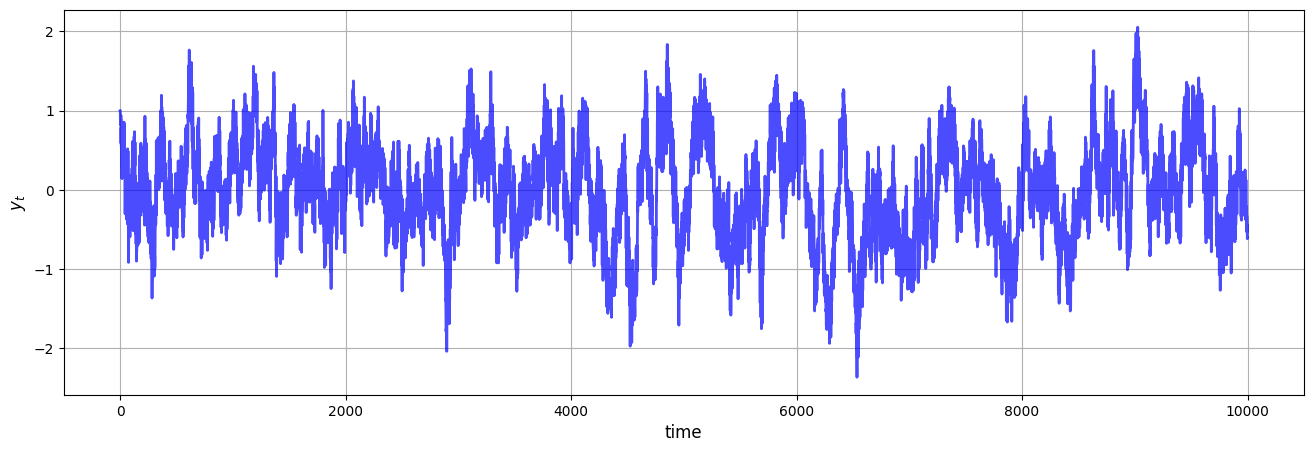

In [183]:
# 1. Import the LinearStateSpace class.

from quantecon import LinearStateSpace

import numpy as np
import matplotlib.pyplot as plt

# 4. Define a wrapper function.

def plot_lss(A, C, G, n, ts_length):

    ar = LinearStateSpace(A, C, G, mu_0=np.ones(n))  # what about Sigma_0?
    x, y = ar.simulate(ts_length,random_state=None)  # recall how random number is generated.

    fig, ax = plt.subplots(1,1,figsize=(16,5))
    y = y.flatten()
    ax.plot(y, 'b-', lw=2, alpha=0.7)
    ax.grid()
    ax.set_xlabel('time', fontsize=12)
    ax.set_ylabel('$y_t$', fontsize=12)
    plt.show()


phi_1, phi_2, phi_3, phi_4, phi_5, phi_6, sigma = 0.276931, 0.286270, 0.286270, 0.578234, -0.325854, -0.136724 ,0.2

A1 = [[phi_1, phi_2, phi_3, phi_4, phi_5, phi_6],
      [1,     0,     0,     0 , 0, 0   ],
      [0,     1,     0,     0, 0, 0    ],
      [0,     0,     1,     0, 0, 0    ],
      [0,     0,     0,     1, 0, 0    ],
      [0,     0,     0,     0, 1, 0    ],
      ]

C1 = [[sigma],[0],[0],[0], [0], [0]]


G1 = [1, 0, 0, 0, 0, 0]

plot_lss(A1, C1, G1, n=6, ts_length = 1000)
plot_lss(A1, C1, G1, n=6, ts_length = 5000)
plot_lss(A1, C1, G1, n=6, ts_length = 10000)

#TESTING FOR ARCH EFFECT for AR(6), indicate there is no arch effect with 95% confidence level

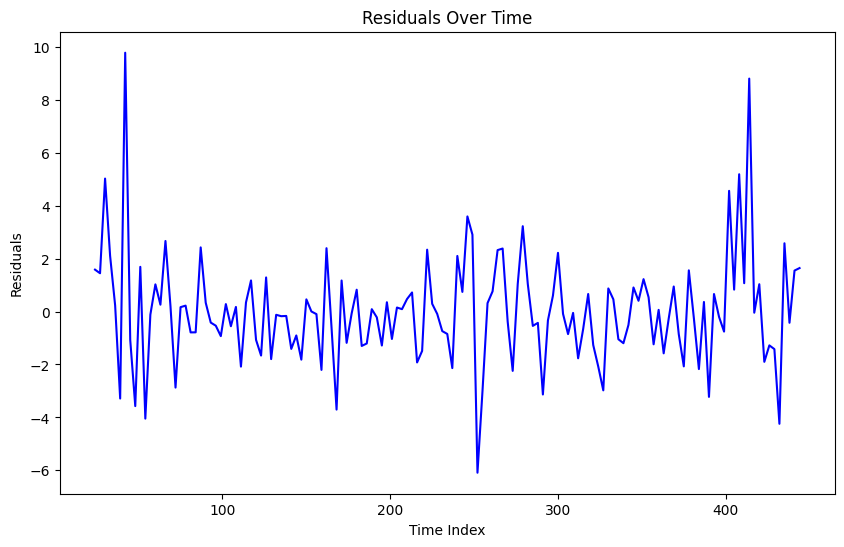

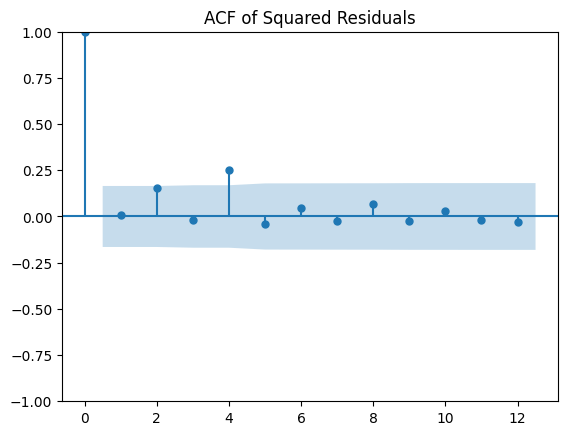

ARCH Test Results:
LM Statistic      13.211904
p-value            0.212064
F-statistic        1.346001
F-test p-value     0.214037
dtype: float64


In [184]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf

# Plot the residuals to visually inspect for volatility clustering
plt.figure(figsize=(10, 6))
plt.plot(residuals, color='blue')
plt.title('Residuals Over Time')
plt.xlabel('Time Index')
plt.ylabel('Residuals')
plt.show()

# Plot the ACF of squared residuals (common way to detect ARCH effects)
plot_acf(residuals ** 2, lags=12, alpha = 0.05)
plt.title('ACF of Squared Residuals')
plt.show()

# Perform the ARCH-LM Test
arch_test = het_arch(residuals)
arch_test_results = pd.Series(arch_test, index=['LM Statistic', 'p-value', 'F-statistic', 'F-test p-value'])

print("ARCH Test Results:")
print(arch_test_results)


#we try to compute AIC BIC for different lag, and we get lower AIC BIC everytime we increase the lag. However based on PACF cutoff, it will be better to choose only at 6 lag due to avoid overfitting

In [185]:

import pandas as pd

results = []
for i in range(1, 10):  # AR models from lag 1 to 9

    model = AutoReg(inflation_rate_series, lags=i)
    model_fit = model.fit()
    aic = model_fit.aic
    bic = model_fit.bic
    results.append([i, aic, bic])
    print(f"AR({i}): AIC={aic:.2f}, BIC={bic:.2f}")

# Find the best models based on AIC and BIC
results_df = pd.DataFrame(results, columns=['Lag', 'AIC', 'BIC'])
best_aic_model = results_df.loc[results_df['AIC'].idxmin()]  # Find row with minimum AIC
best_bic_model = results_df.loc[results_df['BIC'].idxmin()]  # Find row with minimum BIC


print(f"\nBest Model (AIC): Lag {int(best_aic_model['Lag'])}, AIC={best_aic_model['AIC']:.2f}, BIC={best_aic_model['BIC']:.2f}")
print(f"Best Model (BIC): Lag {int(best_bic_model['Lag'])}, AIC={best_bic_model['AIC']:.2f}, BIC={best_bic_model['BIC']:.2f}")

AR(1): AIC=748.06, BIC=757.01
AR(2): AIC=703.38, BIC=715.28
AR(3): AIC=700.63, BIC=715.48
AR(4): AIC=652.76, BIC=670.54
AR(5): AIC=626.82, BIC=647.52
AR(6): AIC=622.70, BIC=646.29
AR(7): AIC=620.78, BIC=647.26
AR(8): AIC=616.83, BIC=646.17
AR(9): AIC=609.03, BIC=641.23

Best Model (AIC): Lag 9, AIC=609.03, BIC=641.23
Best Model (BIC): Lag 9, AIC=609.03, BIC=641.23


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/

# This section will train and predict data with AR(1) adn AR(6) model where we separate train and test data, we get the best prediction model with AR(6) compared to AR(1) date is split in before and after Jun 2022

#Data prediction for AR(1) is constant horizontal line, our assumption is that because the AR(1) coefficient is not significant, so it will only contain constant value


In [186]:
import pandas as pd
import numpy as np


df_inflation_prediction = df_inflation.copy()

# Convert the 'date' column to datetime format and set it as the index in the new DataFrame
df_inflation_prediction['date'] = pd.to_datetime(df_inflation_prediction['date'], format='%Y%m')
df_inflation_prediction.set_index('date', inplace=True)

print(len(df_inflation_prediction))
# Define Train and Test Sets
train_data = df_inflation_prediction.loc[df_inflation_prediction.index <= '2022-06-01', 'Annual Inflation Rate']
test_data = df_inflation_prediction.loc[df_inflation_prediction.index > '2022-06-01', 'Annual Inflation Rate']


147


#function definition

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg

def fit_and_predict_AR_model(lags):
    # Fit the AR model on the training data
    model = AutoReg(train_data, lags=lags)
    model_fit = model.fit()

    # Print the model summary
    print(model_fit.summary())

    # Make predictions for the test data
    predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=True)

    print(predictions)
    predictions.index = test_data.index


   # Plot the results
    plt.figure(figsize=(18, 6))

    # Use the date index for plotting
    plt.plot(train_data.index, train_data, label='Training Data', color='blue')
    plt.plot(test_data.index, test_data, label='Actual Inflation Rate', color='green')
    plt.plot(test_data.index, predictions, label='Predicted Inflation Rate', color='red', linestyle='dashed')

    plt.title(f'Predicted vs Actual Inflation Rate with AR({lags})')
    plt.xlabel('Date (yyyymm)')
    plt.ylabel('Annual Inflation Rate')
    plt.legend()

    # Set x-axis ticks to display all dates without skipping
    plt.xticks(train_data.index.union(test_data.index), rotation=90)  # Rotate x-axis labels to 90 degrees

    # Format x-axis to show year and month
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

    # Adjust layout to make room for the rotated x-axis labels
    plt.tight_layout()

    # Show the plot
    plt.show()


#USING 1 lag

                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  137
Model:                        AutoReg(1)   Log Likelihood                -342.363
Method:                  Conditional MLE   S.D. of innovations              2.999
Date:                   Tue, 15 Apr 2025   AIC                            690.726
Time:                           14:27:05   BIC                            699.464
Sample:                       09-01-1988   HQIC                           694.277
                            - 06-01-2022                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.4004      0.349      6.878      0.000       1.716       3.084
Annual Inflation Rate.L1     0.0880      0.092      0.955      0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


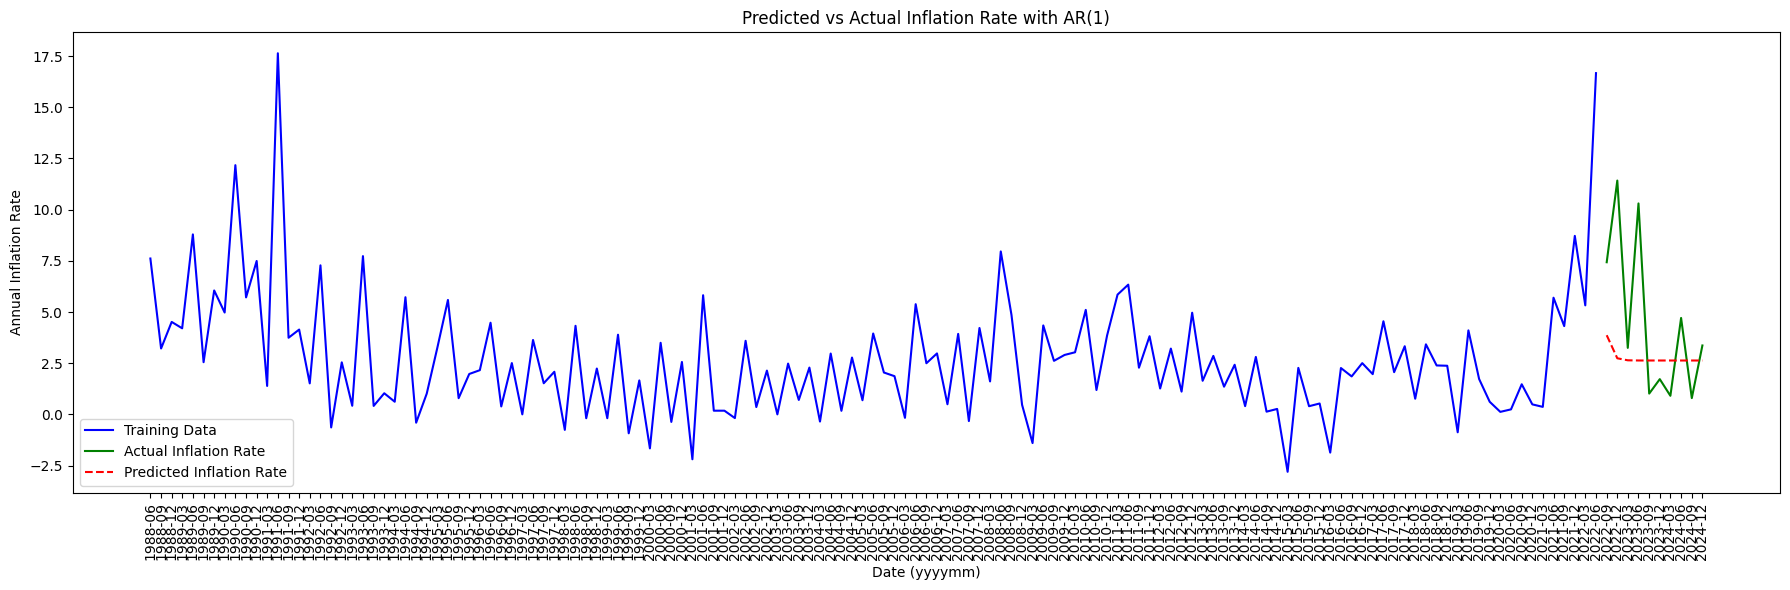

In [188]:
fit_and_predict_AR_model(lags=1)



#Using 6 lags

                              AutoReg Model Results                              
Dep. Variable:     Annual Inflation Rate   No. Observations:                  137
Model:                        AutoReg(6)   Log Likelihood                -281.699
Method:                  Conditional MLE   S.D. of innovations              2.078
Date:                   Tue, 15 Apr 2025   AIC                            579.398
Time:                           14:27:05   BIC                            602.400
Sample:                       12-01-1989   HQIC                           588.745
                            - 06-01-2022                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.6733      0.337      2.001      0.045       0.014       1.333
Annual Inflation Rate.L1     0.3075      0.095      3.246      0.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


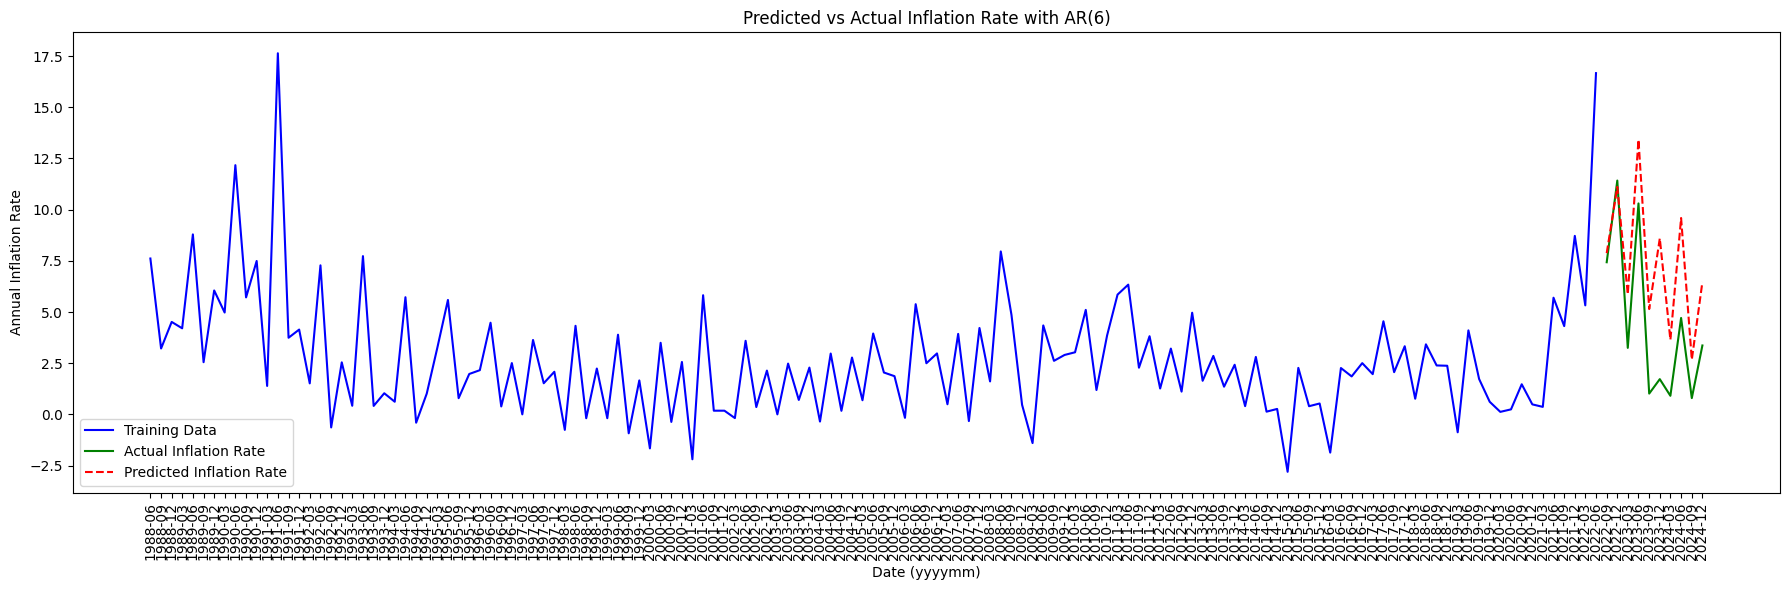

In [189]:
fit_and_predict_AR_model(lags=6)

#Now we try with exogenous variable with ARDL using GDP Quarterly change, Interest Rate Quarterly, and Unemployment Rate Quarterly using 6 lag for CPI inflation rate and 12 lag for exogenous variable

     Quarter  Quarterly GDP
0     198803         133283
1     198806         136630
2     198809         140801
3     198812         144969
4     198903         148623
..       ...            ...
143   202312         685749
144   202403         698800
145   202406         707433
146   202409         717089
147   202412         724724

[148 rows x 2 columns]
     Quarter  Interest Rate
0     197503          10.00
1     197506          10.00
2     197509          11.00
3     197512          11.25
4     197603           9.00
..       ...            ...
196   202403           5.25
197   202406           5.25
198   202409           5.00
199   202412           4.75
200   202503           4.50

[201 rows x 2 columns]
       date  Quarterly GDP  Quarterly GDP Change
1    198806         136630              2.480186
2    198809         140801              3.007100
3    198812         144969              2.917238
4    198903         148623              2.489297
5    198906         151262         

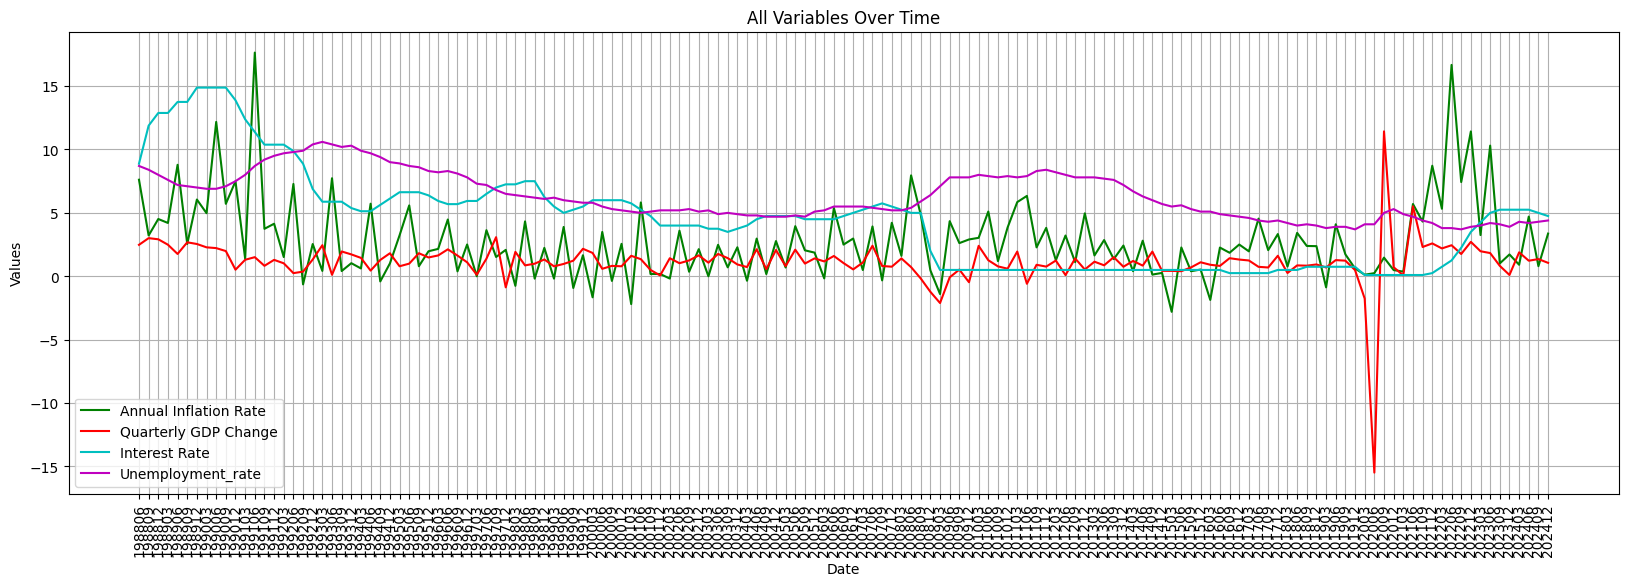

In [190]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
df_gdp = pd.read_csv('GDP Quarterly.csv')
df_interest_rate = pd.read_csv('Interest Rate Quarterly.csv')
df_unemployement = pd.read_csv('Unemployment rate Quarterly.csv')

print(df_gdp)
print(df_interest_rate)
# Rename the date columns for consistency
df_gdp = df_gdp.rename(columns={df_gdp.columns[0]: 'date'})

df_interest_rate = df_interest_rate.rename(columns={df_interest_rate.columns[0]: 'date'})
df_unemployement = df_unemployement.rename(columns={df_unemployement.columns[0]: 'date'})
df_inflation = df_inflation.rename(columns={df_inflation.columns[0]: 'date'})  # Rename index column to 'date'
import numpy as np

# Convert 'Quarterly GDP' column to numeric
df_gdp['Quarterly GDP'] = pd.to_numeric(df_gdp['Quarterly GDP'], errors='coerce')

# Calculate the log quarterly change for GDP
df_gdp['Quarterly GDP Change'] = np.log(df_gdp['Quarterly GDP']).diff() * 100

# Drop the first row with NaN due to differencing
df_gdp.dropna(subset=['Quarterly GDP Change'], inplace=True)

# Display the modified df_gdp
print(df_gdp)


# Ensure all date columns are strings
df_gdp['date'] = df_gdp['date'].astype(str)
df_interest_rate['date'] = df_interest_rate['date'].astype(str)
df_unemployement['date'] = df_unemployement['date'].astype(str)
df_inflation['date'] = df_inflation['date'].astype(str)

# Keep only 'date' and 'Annual Inflation Rate' columns from df_inflation
df_inflation = df_inflation[['date', 'Annual Inflation Rate']]

# Merge all dataframes on 'date'
df_combined = df_inflation.merge(df_gdp, on='date', how='inner') \
                          .merge(df_interest_rate, on='date', how='inner') \
                          .merge(df_unemployement, on='date', how='inner')
# Remove the 'Quarterly GDP' column from df_combined
df_combined = df_combined.drop(columns=['Quarterly GDP'])
print(df_combined)


# Plot all columns on the same graph with different colors
plt.figure(figsize=(20, 6))
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Define some colors
for i, column in enumerate(df_combined.columns):
    if column != 'date':  # Skip the 'date' column
        plt.plot(df_combined['date'], df_combined[column], color=colors[i % len(colors)], label=column)

plt.title('All Variables Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.xticks(rotation=90)
plt.grid(True)
plt.legend()
plt.show()


#Multicolinearity test from correlation matrix

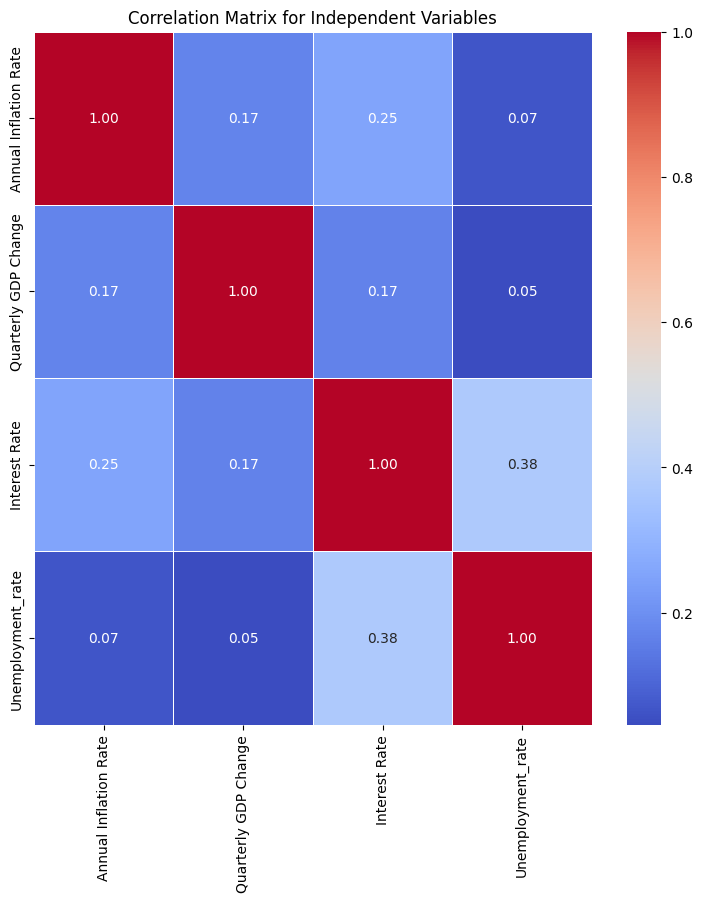

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_combined contains the variables: 'Annual Inflation Rate', 'Quarterly GDP Change', 'Interest Rate', 'Unemployment_rate'
correlation_matrix = df_combined[['Annual Inflation Rate', 'Quarterly GDP Change', 'Interest Rate', 'Unemployment_rate']].corr()

# Plotting the correlation heatmap
plt.figure(figsize=(9, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix for Independent Variables')
plt.show()


#COefficient value for exog and AR variable

The rationale behind using causal=True :
1. Current value of the dependent variable: The future values of the dependent variable (y) can only be predicted based on its past lags (i.e., lagged values of the dependent variable) and the lagged values of the exogenous variables (independent variables), not the current value of the independent variables.

2. Excluding the contemporaneous relationship: If you include the current value of the exogenous variables (i.e., lag 0) when setting causal=False, you are essentially allowing the current value of the exogenous variables to affect the current value of the dependent variable. However, in forecasting, you won't know the future values of these exogenous variables, and so their instantaneous effect is not relevant beyond the last available time point.

In [192]:
import pandas as pd
from statsmodels.tsa.api import ARDL

# Define exogenous variables
exog = df_combined[['Quarterly GDP Change', 'Interest Rate', 'Unemployment_rate']].copy()

# Fit ARDL Model
model = ARDL(df_combined['Annual Inflation Rate'], 11, exog, 7, causal=True)
result = model.fit()

# Display the model summary
print(result.summary())

# Extract p-values and coefficients
pvalues = result.pvalues
coefficients = result.params

# Filter out coefficients with p-values < 0.05
significant_coefs = coefficients[pvalues < 0.05]

# Display the significant coefficients
print("\nSignificant Coefficients with 95% confidence level (p-value < 0.05):")
print(significant_coefs)


                                ARDL Model Results                               
Dep. Variable:     Annual Inflation Rate   No. Observations:                  147
Model:                 ARDL(11, 7, 7, 7)   Log Likelihood                -268.102
Method:                  Conditional MLE   S.D. of innovations              1.737
Date:                   Tue, 15 Apr 2025   AIC                            604.203
Time:                           14:27:06   BIC                            703.234
Sample:                               11   HQIC                           644.447
                                     147                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.9915      0.859      1.154      0.251      -0.713       2.696
Annual Inflation Rate.L1      0.2824      0.100      2.829    

In [193]:
import pandas as pd
import numpy as np


df_combined_prediction = df_combined.copy()

# Convert the 'date' column to datetime format and set it as the index in the new DataFrame
df_combined_prediction['date'] = pd.to_datetime(df_combined_prediction['date'], format='%Y%m')
df_combined_prediction.set_index('date', inplace=True)

# Define Train and Test Sets Using Boolean Indexing
ARDL_train_data = df_combined_prediction.loc[df_combined_prediction.index <= '2022-06-01']


ARDL_test_data = df_combined_prediction.loc[df_combined_prediction.index > '2022-06-01']



In [194]:
import pandas as pd
from statsmodels.tsa.api import ARDL

# Define exogenous variables
exog1 = ARDL_train_data[['Quarterly GDP Change', 'Interest Rate', 'Unemployment_rate']].copy()

# Fit ARDL Model
modeltrain = ARDL(ARDL_train_data['Annual Inflation Rate'], 11, exog1, 7, causal=True)
resultARDL = modeltrain.fit()

# Display the model summary
print(resultARDL.summary())

# Extract p-values and coefficients
pvalues1 = result.pvalues
coefficients1 = result.params

# Filter out coefficients with p-values < 0.05
significant_coefs_ARDL = coefficients1[pvalues < 0.05]

# Display the significant coefficients
print("\nSignificant Coefficients with 95% confidence level (p-value < 0.05):")
print(significant_coefs_ARDL)


                                ARDL Model Results                               
Dep. Variable:     Annual Inflation Rate   No. Observations:                  137
Model:                 ARDL(11, 7, 7, 7)   Log Likelihood                -247.057
Method:                  Conditional MLE   S.D. of innovations              1.719
Date:                   Tue, 15 Apr 2025   AIC                            562.114
Time:                           14:27:06   BIC                            658.547
Sample:                       03-01-1991   HQIC                           601.292
                            - 06-01-2022                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.7720      0.882      0.875      0.384      -0.980       2.524
Annual Inflation Rate.L1      0.2478      0.118      2.094    

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)


2022-09-01    6.111885
2022-12-01    7.681516
2023-03-01    4.070758
2023-06-01    9.148337
2023-09-01    3.176727
2023-12-01    4.797637
2024-03-01    2.171745
2024-06-01    7.708593
2024-09-01    2.083673
2024-12-01    3.878218
Freq: QS-DEC, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


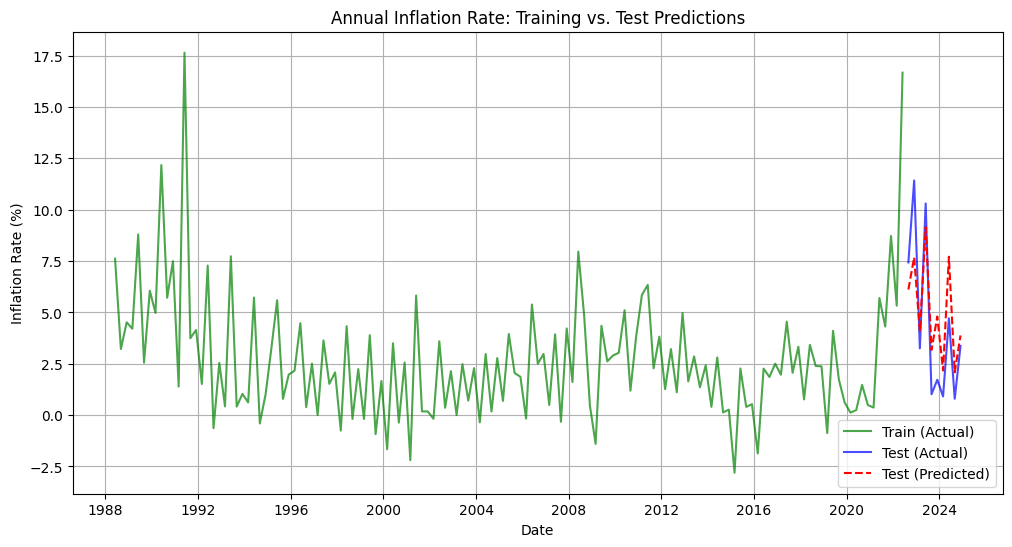

In [195]:
import matplotlib.pyplot as plt

train_inflation = ARDL_train_data['Annual Inflation Rate']

test_inflation = ARDL_test_data['Annual Inflation Rate']


exog_test = ARDL_test_data[['Quarterly GDP Change', 'Interest Rate', 'Unemployment_rate']].copy()
exog_train = ARDL_train_data[['Quarterly GDP Change', 'Interest Rate', 'Unemployment_rate']].copy()


dynamic_predictions = resultARDL.predict(
    start=ARDL_test_data.index[0],
    end=ARDL_test_data.index[-1],
    exog=exog_train,
    exog_oos=exog_test,
    dynamic=False
)


print(dynamic_predictions)

plt.figure(figsize=(12, 6))


plt.plot(ARDL_train_data.index,
         ARDL_train_data['Annual Inflation Rate'],
         label='Train (Actual)', color='green', alpha=0.7)


plt.plot(test_inflation.index,
         test_inflation,
         label='Test (Actual)', color='blue', alpha=0.7)


plt.plot(dynamic_predictions.index,
         dynamic_predictions,
         label='Test (Predicted)', color='red', linestyle='--')


plt.title('Annual Inflation Rate: Training vs. Test Predictions')
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.legend()
plt.grid(True)

plt.show()

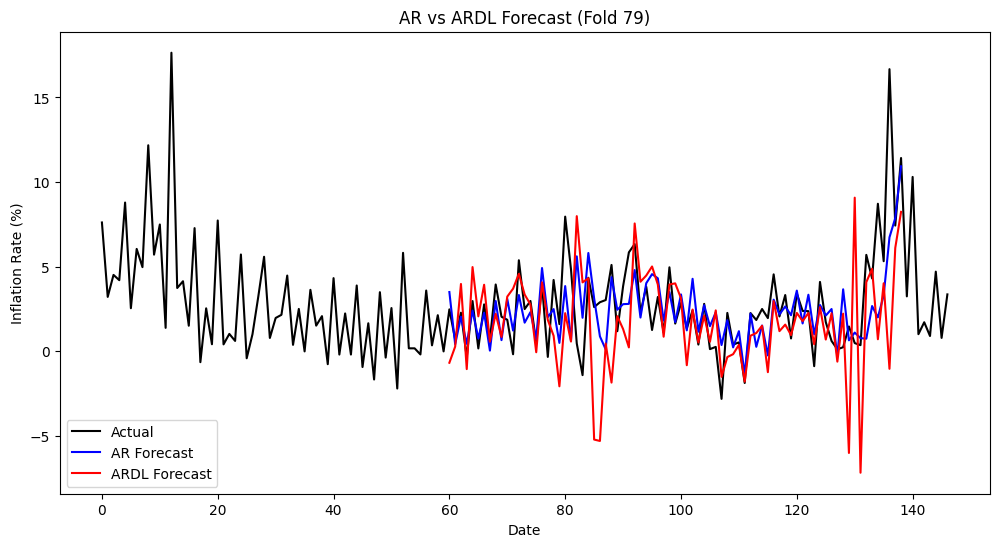

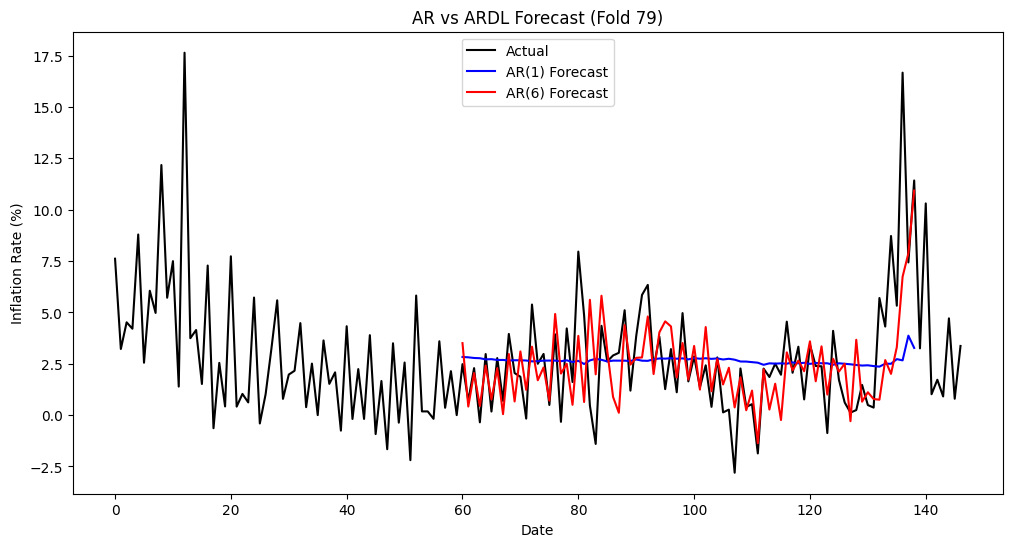

Average RMSE for AR Model: 1.4865
Average RMSE for ARDL Model: 2.3925
Average RMSE for AR(1): 1.9445
Average RMSE for AR(2): 1.6892
Average RMSE for AR(3): 1.6911
Average RMSE for AR(4): 1.5845
Average RMSE for AR(5): 1.4732
Average RMSE for AR(6): 1.4865
Average RMSE for AR(7): 1.5151
Average RMSE for AR(8): 1.5427
Average RMSE for AR(9): 1.5403
Average RMSE for AR(10): 1.5430


In [196]:
from sklearn.metrics import mean_squared_error
# Define the number of folds
n_initial = 60

# Prepare the data
data = df_combined.copy()

target = data['Annual Inflation Rate']
exog = data[['Quarterly GDP Change', 'Interest Rate', 'Unemployment_rate']]

predictions = pd.DataFrame(index=data.index, columns=['AR', 'ARDL', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10'])

# Initialize lists to store RMSE for each fold
ar_rmse = []
ardl_rmse = []
ar_model_rmse = {}

# Perform time series cross-validation
for n in range(n_initial, 140 - 1):
    train_index = np.arange(0, n)
    test_index = np.arange(n, n + 1)
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]
    train_target, test_target = target.iloc[train_index], target.iloc[test_index]
    train_exog, test_exog = exog.iloc[train_index], exog.iloc[test_index]

    # AR Model
    ar_model = AutoReg(train_target, lags=6, old_names=False).fit()
    ar_forecast = ar_model.predict(start=test_data.index[0], end=test_data.index[-1])
    predictions.loc[test_data.index, 'AR'] = ar_forecast
    
    ar_rmse.append(np.sqrt(mean_squared_error(test_target, ar_forecast)))

    for lag in range(1, 11):
        ar_model = AutoReg(train_target, lags=lag, old_names=False).fit()
        ar_forecast = ar_model.predict(start=test_data.index[0], end=test_data.index[-1])
        if lag not in ar_model_rmse.keys():
            ar_model_rmse[lag] = []

        predictions.loc[test_data.index, 'AR' + str(lag)] = ar_forecast
        ar_model_rmse[lag].append(np.sqrt(mean_squared_error(test_target, ar_forecast)))
    
        
        
    # ARDL Model
    ardl_model = ARDL(train_target, lags=11, exog=train_exog, order=7, causal=True)
    result = ardl_model.fit()
    
    
    ardl_forecast = ardl_model.predict(params=result.params, start=test_data.index[0], end=test_data.index[-1], exog_oos=test_exog)
    ardl_rmse.append(np.sqrt(mean_squared_error(test_target, ardl_forecast)))
    predictions.loc[test_data.index, 'ARDL'] = ardl_forecast
    

# Plot the forecast for each iteration
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Annual Inflation Rate'], label='Actual', color='black')
plt.plot(predictions.index, predictions['AR'], label='AR Forecast', color='blue')
plt.plot(predictions.index, predictions['ARDL'], label='ARDL Forecast', color='red')
plt.title(f"AR vs ARDL Forecast (Fold {len(ar_rmse)})")
plt.xlabel("Date")
plt.ylabel("Inflation Rate (%)")
plt.legend()
plt.show()

# Plot the forecast for each iteration
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Annual Inflation Rate'], label='Actual', color='black')
plt.plot(predictions.index, predictions['AR1'], label='AR(1) Forecast', color='blue')
plt.plot(predictions.index, predictions['AR6'], label='AR(6) Forecast', color='red')
plt.title(f"AR vs ARDL Forecast (Fold {len(ar_rmse)})")
plt.xlabel("Date")
plt.ylabel("Inflation Rate (%)")
plt.legend()
plt.show()

# Calculate average RMSE for both models
print(f"Average RMSE for AR Model: {np.mean(ar_rmse):.4f}")
print(f"Average RMSE for ARDL Model: {np.mean(ardl_rmse):.4f}")

for key in ar_model_rmse.keys():
    print(f"Average RMSE for AR({key}): {np.mean(ar_model_rmse[key]):.4f}")




In [197]:

train_exog = exog.iloc[:120]
test_exog = exog.iloc[120:]
train_data = data['Annual Inflation Rate'].iloc[:120]
test_data = data['Annual Inflation Rate'].iloc[120:]
model_ar1 = AutoReg(train_data, lags=1).fit()
model_ar6 = AutoReg(train_data, lags=6).fit()
model_ardl = ARDL(train_data, lags=11, exog=train_exog, order=7, causal=True)
result = model_ardl.fit()

print(test_data.index[0])
print(test_data.index[-1])
# Forecasting
forecast_start = test_data.index[0]
forecast_end = test_data.index[-1]
pred_ar1 = model_ar1.predict(start=forecast_start, end=forecast_end, dynamic=True)
pred_ar6 = model_ar6.predict(start=forecast_start, end=forecast_end, dynamic=True)
pred_ardl = model_ardl.predict(params = result.params, start=forecast_start, end=forecast_end, exog_oos=test_exog, dynamic=False)

print(pred_ar6)

120
146
120    3.590637
121    1.687996
122    3.198336
123    1.123402
124    3.407621
125    1.583662
126    3.084510
127    1.335209
128    3.233323
129    1.568425
130    2.998078
131    1.479408
132    3.085768
133    1.598057
134    2.922819
135    1.584314
136    2.964616
137    1.647860
138    2.853754
139    1.666121
140    2.865668
141    1.704402
142    2.789757
143    1.733668
144    2.784242
145    1.760824
146    2.730868
dtype: float64


In [198]:
rmse_ar1 = np.sqrt(mean_squared_error(test_data, pred_ar1))
rmse_ar6 = np.sqrt(mean_squared_error(test_data, pred_ar6))
rmse_ardl = np.sqrt(mean_squared_error(test_data, pred_ardl))
print(rmse_ar1,rmse_ar6,rmse_ardl)

4.208869253206126 4.088706690316446 4.927812746146055


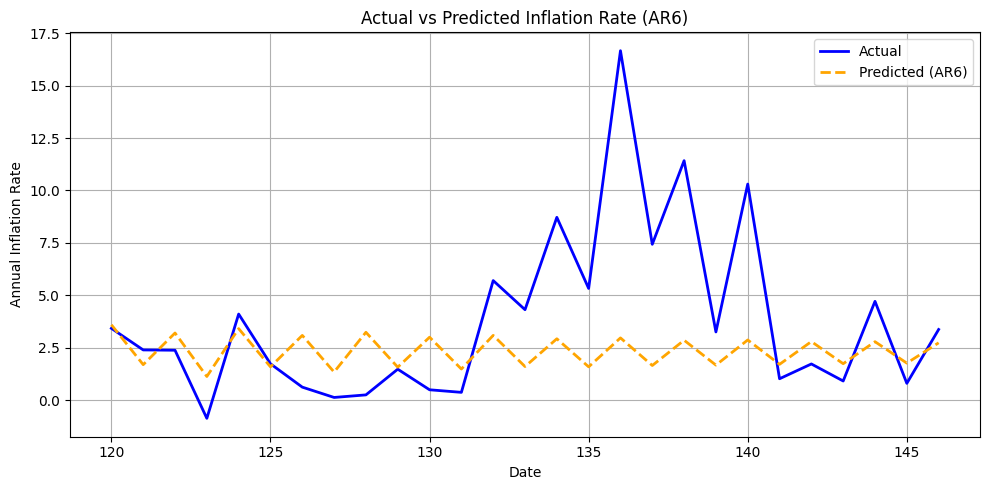

In [199]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot actual test data
plt.plot(test_data, label='Actual', color='blue', linewidth=2)

# Plot predictions from AR(6) model
plt.plot(test_data.index, pred_ar6, label='Predicted (AR6)', color='orange', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Annual Inflation Rate')
plt.title('Actual vs Predicted Inflation Rate (AR6)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/dx/03j3fmjd6r36xwq8nwbzqpn80000gn/T/ipykernel_27360/520900760.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_hat = coef[0] + np.dot(coef[1:], lags)       # Intercept + lag coefficients


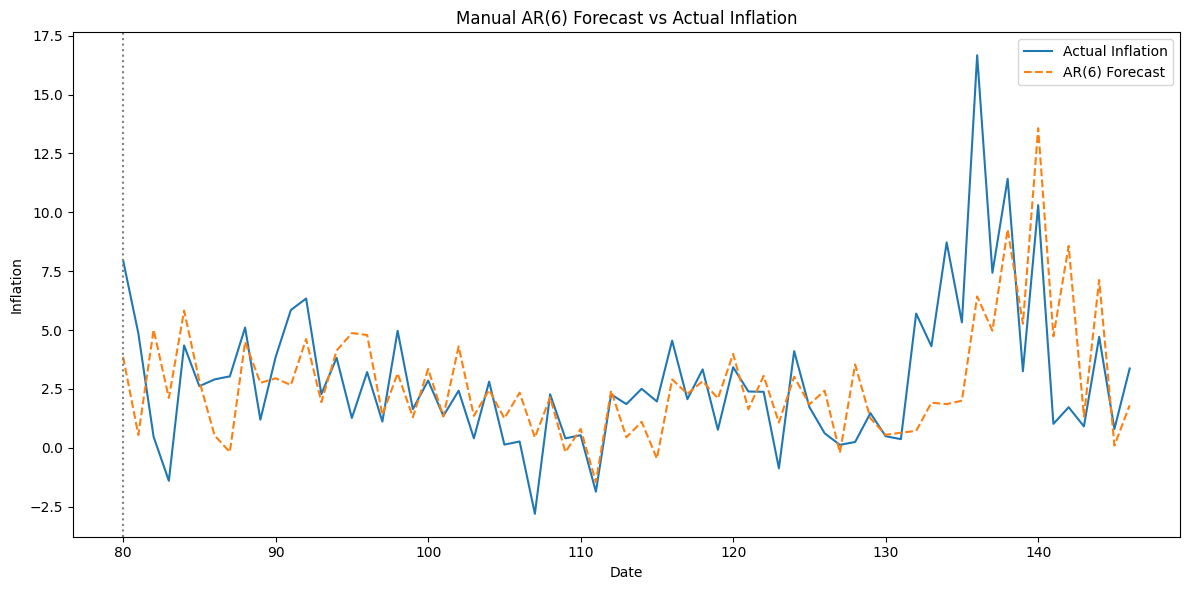

Annual Inflation Rate.L1    0.064814
Annual Inflation Rate.L2    0.171198
Annual Inflation Rate.L3    0.024161
Annual Inflation Rate.L4    0.721796
Annual Inflation Rate.L5   -0.135132
Annual Inflation Rate.L6   -0.061496
dtype: float64


In [200]:
train_data = data['Annual Inflation Rate'].iloc[:80]
test_data = data['Annual Inflation Rate'].iloc[80:]
# 3. Fit AR(6) on train_data only
model_ar6 = AutoReg(train_data, lags=6, old_names=False).fit()
coef = model_ar6.params  # Intercept + 6 coefficients

# 4. Combine full data for manual forecasting
combined_data = pd.concat([train_data, test_data]).copy()

# 5. Manual prediction loop using actual values
pred_ar6 = []

for i in range(len(train_data), len(combined_data)):
    lags = combined_data.iloc[i-6:i].values[::-1]  # 6 lagged actual values, reversed
    y_hat = coef[0] + np.dot(coef[1:], lags)       # Intercept + lag coefficients
    pred_ar6.append(y_hat)

# 6. Store as a Series
pred_ar6 = pd.Series(pred_ar6, index=test_data.index)

# 7. Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(test_data, label="Actual Inflation")
plt.plot(pred_ar6, label="AR(6) Forecast", linestyle='--')
plt.axvline(x=test_data.index[0], color='gray', linestyle=':')
plt.title("Manual AR(6) Forecast vs Actual Inflation")
plt.xlabel("Date")
plt.ylabel("Inflation")
plt.legend()
plt.tight_layout()
plt.show()

print(coef[1:])

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ARDL


# Split data into train and test sets
train_exog = exog.iloc[:120]
test_exog = exog.iloc[120:]
train_data = data['Annual Inflation Rate'].iloc[:120]
test_data = data['Annual Inflation Rate'].iloc[120:]

# ARDL model (Endogenous: train_data, Exogenous: train_exog)
model_ardl = ARDL(train_data, lags=11, exog=train_exog, order=7, causal=True)
result = model_ardl.fit()


# Forecasting manually (using the coefficients and lagged values)
predictions = []
for i in range(len(train_data), len(train_data) + len(test_data)):
    # Get lagged endogenous values (y) and exogenous values (X)
    lags_y = np.array(data.iloc[i-11:i].values[::-1])  # Ensure lags_y is a numpy array
    lags_X = np.array(exog.iloc[i-11:i].values[::-1])  # Ensure lags_X is a numpy array
    
    # Coefficients from the fitted model
    intercept = result.params[0]
    y_coeffs = result.params[1:12]  # Coefficients for the lags of y (endogenous)
    x_coeffs = result.params[12:23]  # Coefficients for the lags of X (exogenous)
    
    # ARDL model formula
    y_hat = intercept + np.dot(y_coeffs, lags_y) + np.dot(x_coeffs, lags_X)
    predictions.append(y_hat)

# Convert predictions to a Pandas Series with the corresponding test dates
predictions_series = pd.Series(predictions, index=test_data.index)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(data, label='Actual Data')  # Plot actual data
plt.plot(predictions_series.index, predictions_series, label='Predicted Data', linestyle='--')  # Plot predicted data
plt.axvline(x=test_data.index[0], color='gray', linestyle=':')
plt.legend()
plt.title('Manual ARDL Model Forecast')
plt.show()

# Print predictions
print(predictions_series)


/var/folders/dx/03j3fmjd6r36xwq8nwbzqpn80000gn/T/ipykernel_27360/2510796184.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = result.params[0]


TypeError: can't multiply sequence by non-int of type 'float'